# Results figure --- seasonal spatial variation in continental and glacial river contributions 

In [1]:
import pickle
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cmocean

%matplotlib inline

#### Parameters:

In [60]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202206/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202206/'
folder_cont = '/data/brogalla/run_storage/river-continental-202206/'

# Boundary coordinates:
xmin=imin+1; ymin=jmin+1;
r1i = 1520-xmin;                      r1j = np.arange(505-ymin,673-ymin)
N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin #Nares
P1i = 1585-xmin;                      P1j = np.arange(485-ymin,538-ymin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]

land_color = '#a9a7a2'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

#### Load files:

In [61]:
# ANHA12 mesh:
mesh          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mesh.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mesh.variables['nav_lon'])
lat_ANHA12    = np.array(mesh.variables['nav_lat'])
e3t           = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
hdept         = np.array(mesh.variables['hdept'])[0,imin:imax,jmin:jmax]

In [62]:
# Mn model grid:
ref         = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202204/ANHA12_ref-2002_20220422/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub     = np.array(ref.variables['nav_lon'])
lat_sub     = np.array(ref.variables['nav_lat'])
depth_model = np.array(ref.variables['deptht'])

#### Functions:

In [63]:
def load_Mn_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
    
    return dmn_ref, dmn_glac, dmn_cont

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [64]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off)*100*2 # times two so that 100% 
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [65]:
def calculate_depth_weighted(var, levels=(0,16)):
    # Input arguments:
    # - var(t,z,y,x) --- variable 
    
    e3t_tile         = np.tile(e3t, (12,1,1,1))
    var_weighted     = var[:,levels[0]:levels[1],:,:]*e3t_tile[:,levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]):
    depth_bottom     = np.copy(hdept)
    depth_bottom[depth_bottom == 0] = np.nan
    # where bottom is deeper than levels[1], use depth of levels[1]
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1] 
                 
    # calculate average:
    var_weighted_ave = np.nansum(var_weighted, axis=1) / depth_bottom
    
    # Output:
    # - var_weighted_ave(t,y,x) --- depth-weighted average of variable for each horizontal grid location
    return var_weighted_ave

#### Calculations:

In [66]:
dmn_ref.shape

(12, 50, 700, 640)

In [67]:
dmn_ref, dmn_glac, dmn_cont = load_Mn_results()

depth_weighted_ref  = calculate_depth_weighted(dmn_ref, levels=(0,16))
depth_weighted_glac = calculate_depth_weighted(dmn_glac, levels=(0,16))
depth_weighted_cont = calculate_depth_weighted(dmn_cont, levels=(0,16))

glacier_prop     = calculate_prop(depth_weighted_ref, depth_weighted_glac)
continental_prop = calculate_prop(depth_weighted_ref, depth_weighted_cont)
# continental_prop = calculate_prop(dmn_ref[:,0,:,:], dmn_cont[:,0,:,:])

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [68]:
# Mask small values:
ma_glac = np.ma.masked_where((glacier_prop < 0.05), glacier_prop)
ma_cont = np.ma.masked_where((continental_prop < 0.05), continental_prop)

#### Figures

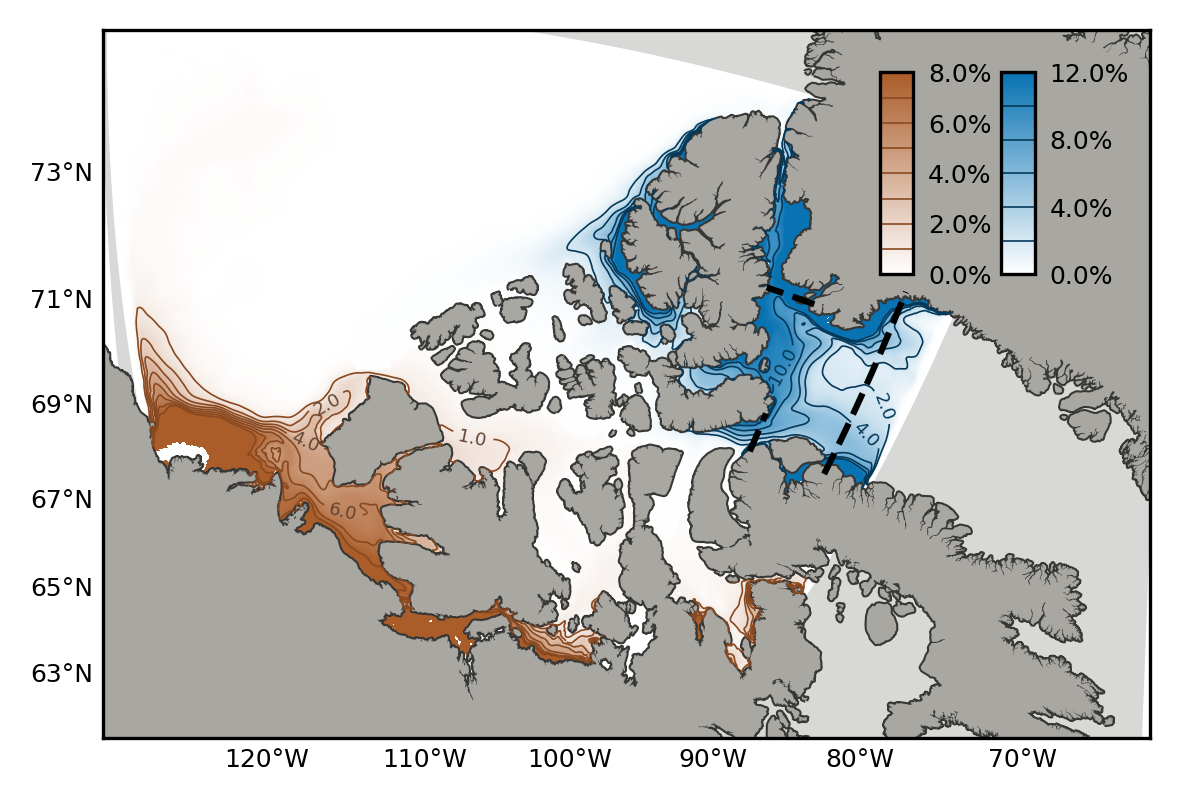

In [69]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-CAA.pickle','rb'))

#---------------------
x_model, y_model   = proj1(lon_sub, lat_sub)
x_ANHA12, y_ANHA12 = proj1(lon_ANHA12, lat_ANHA12)

vmin_cont = 0; vmax_cont = 8;
vmin_glac = 0; vmax_glac = 12;

CS2 = proj1.pcolormesh(x_model, y_model, np.ma.mean(ma_cont[:,:,:], axis=0), vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap)
CS1 = proj1.pcolormesh(x_model, y_model, np.ma.mean(ma_glac[:,:,:], axis=0), vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)

# Contour lines:
glac_levels = [2,4,6,8,10]
cont_levels = [1,2,3,4,5,6,7,8]
glac = proj1.contour(x_model, y_model, np.ma.mean(ma_glac[:,:,:], axis=0), levels=glac_levels, colors='#04395a', linewidths=0.4)
cont = proj1.contour(x_model, y_model, np.ma.mean(ma_cont[:,:,:], axis=0), levels=cont_levels, colors='#894920', linewidths=0.4)

# Draw flux boundary:
proj1.plot(x_model[P1i, P1j], y_model[P1i, P1j], '--k', linewidth=1.5)
proj1.plot(x_model[r1i, r1j], y_model[r1i, r1j], '--k', linewidth=1.5)
proj1.plot(x_model[N1i, N1j], y_model[N1i, N1j], '--k', linewidth=1.5)

# Draw domain boundaries:
# consider adding plus rimwidth of boundary 
ax1.fill_between(x_ANHA12[imin,:], y_ANHA12[imin,:], y_ANHA12[0,:], color='#d8d8d6')
ax1.fill_between(x_ANHA12[:,jmax], y_ANHA12[:,jmax], y_ANHA12[:,-1], color='#d8d8d6')
ax1.fill_between(x_ANHA12[imax,:], y_ANHA12[imax,:], y_ANHA12[-1,:], color='#d8d8d6')

# Contour line labels:
manual_locations_cont = [(1.2e6, 1.0e6), (6.5e5, 9.5e5), (7.5e5, 6.8e5), (7.4e5, 10.7e5)]
manual_locations_glac = [(2.5e6, 1.0e6), (2.55e6, 1.08e6), (2.22e6, 1.2e6)]
ax1.clabel(cont, [1,2,3,4,5,6], inline=1, fontsize=4.3, manual=manual_locations_cont, colors='#624532', fmt='%.1f')
ax1.clabel(glac, [2,4,6,8,10], inline=1, manual=manual_locations_glac, fontsize=4.3, fmt='%1.1f')

# Colorbars:
cbaxes1 = fig.add_axes([0.79, 0.60, 0.025, 0.18])  
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, ticks=[0,4,8,12])
CBar1.add_lines(glac)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.1f}%' for i in CBar1.get_ticks()]);

cbaxes2 = fig.add_axes([0.70, 0.60, 0.025, 0.18]) 
CBar2   = plt.colorbar(CS2, ax=ax1, cax=cbaxes2, ticks=[0,2,4,6,8]) 
CBar2.add_lines(cont)
CBar2.ax.tick_params(axis='y', length=0, labelsize=6)
CBar2.ax.set_yticklabels([f'{i:.1f}%' for i in CBar2.get_ticks()]);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/R3-mean-field.jpg', bbox_inches='tight', dpi=300)

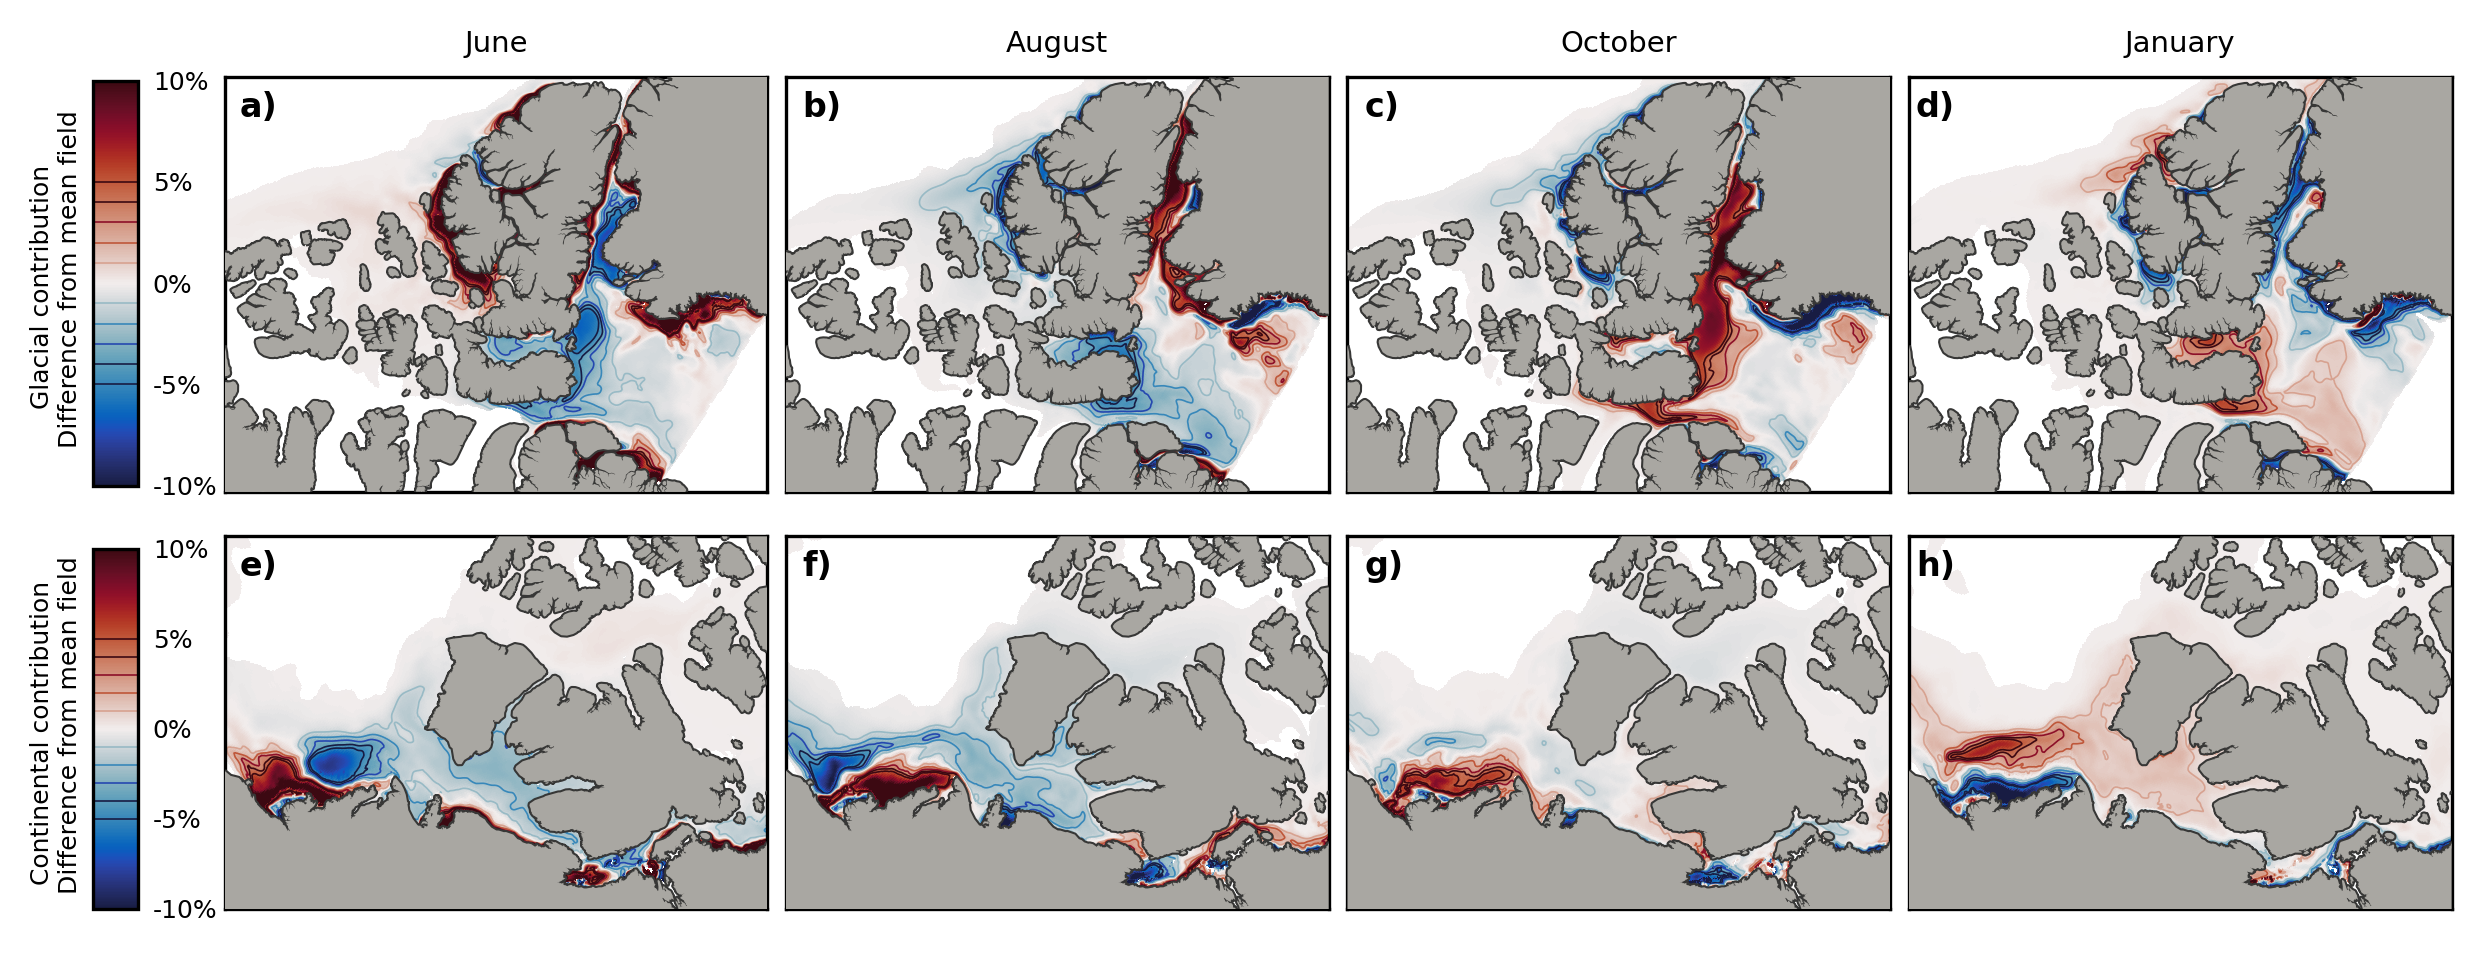

In [12]:
fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-seasonal.pickle','rb'))

#---------------------
x_model1, y_model1 = proj1(lon_sub, lat_sub)
x_model2, y_model2 = proj2(lon_sub, lat_sub)

# Contour lines:
glac_levels = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
cont_levels = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
top = 10

months=[5,7,9,0]
titles=['June','August','October','January']

for m,axis in enumerate(ax[0,:].ravel()):    
    CS1 = proj1.pcolormesh(x_model1, y_model1, ma_glac[months[m],:,:]-np.ma.mean(ma_glac[:,:,:], axis=0), \
                           vmin=-top, vmax=top, cmap=cmocean.cm.balance, ax=axis)
    glac = proj1.contour(x_model1, y_model1, ma_glac[months[m],:,:]-np.ma.mean(ma_glac[:,:,:], axis=0), \
                         levels=glac_levels, vmin=-4, vmax=4, cmap=cmocean.cm.balance, linewidths=0.4, ax=axis)
    axis.set_title(titles[m], fontsize=7)
    
for m,axis in enumerate(ax[1,:].ravel()):    
    CS2 = proj2.pcolormesh(x_model2, y_model2, ma_cont[months[m],:,:]-np.ma.mean(ma_cont[:,:,:], axis=0), \
                           vmin=-top, vmax=top, cmap=cmocean.cm.balance, ax=axis)
    cont = proj2.contour(x_model2, y_model2, ma_cont[months[m],:,:]-np.ma.mean(ma_cont[:,:,:], axis=0), \
                         levels=cont_levels, vmin=-4, vmax=4, cmap=cmocean.cm.balance, linewidths=0.4, ax=axis)

# Colorbars:
cbaxes1 = fig.add_axes([-0.05, 0.52, 0.02, 0.45])  
CBar1   = plt.colorbar(CS1, ax=ax[0,0], cax=cbaxes1, ticks=[-15, -10, -5, 0, 5, 10, 15])
CBar1.add_lines(glac)
CBar1.set_label('Glacial contribution \n Difference from mean field', labelpad=-45, fontsize=6)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.0f}%' for i in CBar1.get_ticks()]);

cbaxes2 = fig.add_axes([-0.05, 0.05, 0.02, 0.40]) 
CBar2   = plt.colorbar(CS2, ax=ax[1,0], cax=cbaxes2, ticks=[-15, -10, -5, 0, 5, 10, 15]) 
CBar2.add_lines(cont)
CBar2.set_label('Continental contribution \n Difference from mean field', labelpad=-45, fontsize=6)
CBar2.ax.tick_params(axis='y', length=0, labelsize=6)
CBar2.ax.set_yticklabels([f'{i:.0f}%' for i in CBar2.get_ticks()]);

# add text labels:
fig.text(0.015, 0.93, 'a)', fontsize=8, weight='bold');
fig.text(0.265, 0.93, 'b)', fontsize=8, weight='bold');
fig.text(0.515, 0.93, 'c)', fontsize=8, weight='bold');
fig.text(0.76, 0.93, 'd)', fontsize=8, weight='bold');

fig.text(0.015, 0.42, 'e)', fontsize=8, weight='bold');
fig.text(0.265, 0.42, 'f)', fontsize=8, weight='bold');
fig.text(0.515, 0.42, 'g)', fontsize=8, weight='bold');
fig.text(0.76, 0.42, 'h)', fontsize=8, weight='bold');

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/R4-seasonal-variation.jpg', bbox_inches='tight', dpi=300)